The depth and blendshapes data is being recroded at a lower frame rate than videos.

* ✅ What is the actual fps for depth data? With mean and std over the dataset.
* Scatter plot fps for video against depth (averages over dataset and separately for varg_002)
* Scatter plot fps for video against blendshapes for varg_003
* Are the longer frame drops of depth data correlated with occlusions or not? 

In [1]:
import os, json, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Function to parse timecode in HH:MM:SS:FF.ms format to milliseconds
def timecode_to_milliseconds(timecode, fps=60):
    hh, mm, ss, frames_ms = timecode.split(':')
    frames, ms = frames_ms.split('.')
    return (
        int(hh) * 3600 * 1000 +
        int(mm) * 60 * 1000 +
        int(ss) * 1000 +
        int(frames) * (1000 / fps) +
        int(ms)
    )

In [15]:
# 127 folders total in the root directory (this includes "bad" takes, actually I have 90 good takes)

count_files_progress = 0
all_depth_fps = []

for root, dirs, files in os.walk("./"):
    if root.split('/')[-1].startswith("20241101"):
        video_fps = 60
        num_frames = 0
        duration_seconds = 0
        
        json_path = os.path.join(root, f"take.json")
        with open(json_path, 'r') as f:
            data = json.load(f)
            # this is a Video (!) fps, depth and blendshapes have different fps values 
            video_fps = data["videoTargetFrameRate"]
            num_frames = int(data["frames"])
            start_timecode = data["startTimecode"]
            end_timecode = data["endTimecode"]
            # Calculate the duration of the take in seconds
            start_time_based_on_video = timecode_to_milliseconds(start_timecode, video_fps)
            end_time_based_on_video = timecode_to_milliseconds(end_timecode, video_fps)
            duration_seconds = (end_time_based_on_video - start_time_based_on_video) / 1000

        file = "frame_log.csv"
        print(os.path.join(root, file))
        frame_log_df = pd.read_csv(
             os.path.join(root, file),
             header=None
             )
        frame_log_df.columns = ["data_type", "frame_number", "timestamp_iphone", "timescale", "timecode_tentacle", "unclear"]
        if "B" in frame_log_df["data_type"].unique():
            continue
        # count D in column data_type
        num_frames_depth = len(frame_log_df[frame_log_df["data_type"] == "D"])
        fps_depth = num_frames_depth / duration_seconds
        all_depth_fps.append(fps_depth)

        # transform timecode_tentacle to milliseconds
        frame_log_df["timecode_tentacle_ms"] = frame_log_df["timecode_tentacle"].apply(lambda x: timecode_to_milliseconds(x, video_fps))

        # Scatter plot of the timecode_tentacle_ms
        """plt.figure()
        plt.scatter(frame_log_df[frame_log_df["data_type"] == "V"]["timecode_tentacle_ms"], [1]*num_frames, c="blue")
        plt.scatter(frame_log_df[frame_log_df["data_type"] == "D"]["timecode_tentacle_ms"], [2]*num_frames_depth, c="green", marker="x")
        plt.legend(["Video", "Depth"], loc="upper right")
        plt.title(f"Video and Depth frames timecode in {root.split('/')[-1]}")
        plt.xlabel("Timecode in milliseconds")
        plt.savefig(f"{root.split('/')[-1]}_timecode_scatter.png")
        break"""

        count_files_progress += 1
        print(f"Progress: {count_files_progress/126 * 100}%")

print(f"Average depth fps: {np.mean(all_depth_fps)}")
print(f"Median depth fps: {np.median(all_depth_fps)}")
print(f"Max depth fps: {np.max(all_depth_fps)}")
print(f"Min depth fps: {np.min(all_depth_fps)}")
print(f"Std depth fps: {np.std(all_depth_fps)}")

./20241101_static_ROOF_fingers_contact_at_45_degrees_neutral_location_001_1/frame_log.csv
Progress: 0.7936507936507936%
./20241101_varg_001_1/frame_log.csv
Progress: 1.5873015873015872%
./20241101_bi_005_5/frame_log.csv
Progress: 2.380952380952381%
./20241101_fran_001_1/frame_log.csv
Progress: 3.1746031746031744%
./20241101_parti-vill-kalla-grupp-for-terrorister-1-det_001_1/frame_log.csv
Progress: 3.968253968253968%
./20241101_parti-vill-kalla-grupp-for-terrorister-4-nu_002_2/frame_log.csv
Progress: 4.761904761904762%
./20241101_katt_001_1/frame_log.csv
Progress: 5.555555555555555%
./20241101_bok_002_2/frame_log.csv
Progress: 6.349206349206349%
./20241101_varg_003_3/frame_log.csv
./20241101_parti-vill-kalla-grupp-for-terrorister-1-det_003_3/frame_log.csv
Progress: 7.142857142857142%
./20241101_djur_001_1/frame_log.csv
Progress: 7.936507936507936%
./20241101_abborre_002_2/frame_log.csv
Progress: 8.73015873015873%
./20241101_parti-vill-kalla-grupp-for-terrorister-5-bosattarna_003_3/frame

```
Average depth fps: 30.04652574681187
Median depth fps: 30.049866848262766
Max depth fps: 30.36798856734548
Min depth fps: 28.661677065986996
Std depth fps: 0.13488471608680216
```

### Switch video based frame numbers to timecodes from the `frame_log.csv`

In [62]:
with np.load("occlusions_results.npz", allow_pickle=True) as data:
    video_occlusions = data["video_occlusions"].item()
    video_blendshapes = data["video_blendshapes"].item()

In [68]:
len(video_blendshapes["touch_chin_with_index_finger_middle_of_the_chin_active_hand_001_1_pmil"])

442

In [ ]:
for video in video_occlusions:
    print(f"Interval for video {video}: {video_occlusions[video]}")

    # path for frame_log.csv
    frame_log_path = "./20241101_" + video[:-5] + "/frame_log.csv"
    frame_log_df = pd.read_csv(
        frame_log_path,
        header=None
    )
    frame_log_df.columns = ["data_type", "frame_number", "timestamp_iphone", "timescale", "timecode_tentacle", "unclear"]
    if "B" in frame_log_df["data_type"].unique():
        continue

    for interval in video_occlusions[video]:
        start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
        end_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[1]]["timecode_tentacle"].item()
        print(f"Occlusion: start {start_occlusion}, end {end_occlusion}, duration ms: {timecode_to_milliseconds(end_occlusion, 60) - timecode_to_milliseconds(start_occlusion, 60):.4f}\n")
        video_occlusions[video][video_occlusions[video].index(interval)] = (start_occlusion, end_occlusion)

# save to npz instead of frames
np.savez("occlusions_results_timecodes.npz", video_occlusions=video_occlusions)

Interval for video static_ROOF_fingers_contact_at_45_degrees_neutral_location_001_1_pmil: []
Interval for video varg_001_1_pmil: [(115, 119), (123, 124), (467, 475), (488, 490), (491, 493), (494, 495), (504, 511), (512, 513), (514, 514), (515, 519), (520, 522), (536, 538), (568, 585), (747, 756), (759, 763), (764, 765), (766, 768), (786, 794), (795, 795), (796, 801), (802, 803)]
Occlusion: start 16:07:19:10.059, end 16:07:19:14.059, duration ms: 66.6667

Occlusion: start 16:07:19:18.059, end 16:07:19:19.059, duration ms: 16.6667

Occlusion: start 16:07:25:02.057, end 16:07:25:10.057, duration ms: 133.3333

Occlusion: start 16:07:25:23.057, end 16:07:25:25.057, duration ms: 33.3333

Occlusion: start 16:07:25:26.057, end 16:07:25:28.057, duration ms: 33.3333

Occlusion: start 16:07:25:29.057, end 16:07:25:30.057, duration ms: 16.6667

Occlusion: start 16:07:25:39.057, end 16:07:25:46.057, duration ms: 116.6667

Occlusion: start 16:07:25:47.057, end 16:07:25:48.057, duration ms: 16.6667



/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[1]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean S

Occlusion: start 15:05:09:22.346, end 15:05:09:23.346, duration ms: 16.6667

Occlusion: start 15:05:09:26.346, end 15:05:09:30.346, duration ms: 66.6667

Interval for video nytt-forslag-om-invandrare-1-regeringen_002_2_pmil: []
Interval for video bi_002_2_pmil: [(388, 405), (408, 421), (425, 426), (430, 431), (487, 488)]
Occlusion: start 15:15:14:10.021, end 15:15:14:27.021, duration ms: 283.3333

Occlusion: start 15:15:14:30.021, end 15:15:14:43.021, duration ms: 216.6667

Occlusion: start 15:15:14:47.021, end 15:15:14:48.021, duration ms: 16.6667

Occlusion: start 15:15:14:52.021, end 15:15:14:53.021, duration ms: 16.6667

Occlusion: start 15:15:15:49.021, end 15:15:15:50.021, duration ms: 16.6667

Interval for video nytt-forslag-om-invandrare-3-nu_001_1_pmil: [(252, 258), (350, 358), (359, 363), (364, 365), (425, 427)]
Occlusion: start 17:27:54:40.016, end 17:27:54:46.016, duration ms: 100.0000

Occlusion: start 17:27:56:18.016, end 17:27:56:26.016, duration ms: 133.3333

Occlusion:

/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[1]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean S

Occlusion: start 14:59:59:57.464, end 14:59:59:57.464, duration ms: 0.0000

Occlusion: start 14:59:59:58.464, end 14:59:59:58.464, duration ms: 0.0000

Occlusion: start 14:59:59:59.464, end 14:59:59:59.464, duration ms: 0.0000

Occlusion: start 15:00:00:00.464, end 15:00:00:00.464, duration ms: 0.0000

Occlusion: start 15:00:00:01.464, end 15:00:00:01.464, duration ms: 0.0000

Occlusion: start 15:00:00:02.464, end 15:00:00:02.464, duration ms: 0.0000

Occlusion: start 15:00:00:03.464, end 15:00:00:03.464, duration ms: 0.0000

Occlusion: start 15:00:00:04.464, end 15:00:00:04.464, duration ms: 0.0000

Occlusion: start 15:00:00:05.464, end 15:00:00:05.464, duration ms: 0.0000

Occlusion: start 15:00:00:06.464, end 15:00:00:06.464, duration ms: 0.0000

Occlusion: start 15:00:00:07.464, end 15:00:00:07.464, duration ms: 0.0000

Occlusion: start 15:00:00:08.464, end 15:00:00:08.464, duration ms: 0.0000

Occlusion: start 15:00:00:09.464, end 15:00:00:09.464, duration ms: 0.0000

Occlusion: s

/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[1]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[1]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Ser

Occlusion: start 16:08:14:07.045, end 16:08:14:07.045, duration ms: 0.0000

Occlusion: start 16:08:14:08.045, end 16:08:14:11.045, duration ms: 50.0000

Occlusion: start 16:08:14:12.045, end 16:08:14:16.045, duration ms: 66.6667

Occlusion: start 16:08:14:24.045, end 16:08:14:25.045, duration ms: 16.6667

Occlusion: start 16:08:14:27.045, end 16:08:14:29.045, duration ms: 33.3333

Occlusion: start 16:08:14:36.045, end 16:08:14:38.045, duration ms: 33.3333

Occlusion: start 16:08:15:03.045, end 16:08:15:15.045, duration ms: 200.0000

Occlusion: start 16:08:17:55.044, end 16:08:18:00.044, duration ms: 83.3333

Occlusion: start 16:08:18:01.044, end 16:08:18:05.044, duration ms: 66.6667

Occlusion: start 16:08:18:12.044, end 16:08:18:16.044, duration ms: 66.6667

Occlusion: start 16:08:18:36.044, end 16:08:18:50.044, duration ms: 233.3333

Occlusion: start 16:08:18:51.044, end 16:08:18:54.044, duration ms: 50.0000

Occlusion: start 16:08:18:55.044, end 16:08:18:56.044, duration ms: 16.6667

/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[1]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean S

Occlusion: start 17:26:56:13.034, end 17:26:56:17.034, duration ms: 66.6667

Interval for video tack_001_1_pmil: []
Interval for video krama_001_1_pmil: [(779, 783), (1209, 1210)]
Occlusion: start 15:11:07:19.160, end 15:11:07:23.160, duration ms: 66.6667

Occlusion: start 15:11:14:29.156, end 15:11:14:30.156, duration ms: 16.6667

Interval for video face-calib_001_1_pmil: []
Interval for video a-pose_001_1_pmil: []
Interval for video parti-vill-kalla-grupp-for-terrorister-2-men_004_4_pmil: [(394, 402), (404, 409)]
Occlusion: start 17:06:04:57.437, end 17:06:05:05.437, duration ms: 133.3333

Occlusion: start 17:06:05:07.437, end 17:06:05:12.437, duration ms: 83.3333

Interval for video kontor_001_1_pmil: [(502, 503), (506, 507)]
Occlusion: start 15:14:10:04.058, end 15:14:10:05.058, duration ms: 16.6667

Occlusion: start 15:14:10:08.058, end 15:14:10:09.058, duration ms: 16.6667

Interval for video nytt-forslag-om-invandrare-5-en_001_1_pmil: [(120, 124), (178, 179), (194, 208), (209, 2

/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[1]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean S

Occlusion: start 15:55:22:58.253, end 15:55:22:58.253, duration ms: 0.0000

Occlusion: start 15:55:22:59.253, end 15:55:22:59.253, duration ms: 0.0000

Occlusion: start 15:55:23:00.253, end 15:55:23:00.253, duration ms: 0.0000

Occlusion: start 15:55:23:01.253, end 15:55:23:01.253, duration ms: 0.0000

Occlusion: start 15:55:23:02.253, end 15:55:23:02.253, duration ms: 0.0000

Occlusion: start 15:55:23:03.253, end 15:55:23:03.253, duration ms: 0.0000

Occlusion: start 15:55:23:04.253, end 15:55:23:04.253, duration ms: 0.0000

Occlusion: start 15:55:23:05.253, end 15:55:23:05.253, duration ms: 0.0000

Occlusion: start 15:55:23:06.253, end 15:55:23:06.253, duration ms: 0.0000

Occlusion: start 15:55:23:07.253, end 15:55:23:07.253, duration ms: 0.0000

Occlusion: start 15:55:23:08.253, end 15:55:23:08.253, duration ms: 0.0000

Occlusion: start 15:55:23:09.253, end 15:55:23:09.253, duration ms: 0.0000

Occlusion: start 15:55:23:10.253, end 15:55:23:10.253, duration ms: 0.0000

Occlusion: s

/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[1]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean S

Occlusion: start 14:57:28:02.511, end 14:57:28:02.511, duration ms: 0.0000

Occlusion: start 14:57:28:03.511, end 14:57:28:03.511, duration ms: 0.0000

Occlusion: start 14:57:28:04.511, end 14:57:28:04.511, duration ms: 0.0000

Occlusion: start 14:57:28:05.511, end 14:57:28:05.511, duration ms: 0.0000

Occlusion: start 14:57:28:06.511, end 14:57:28:06.511, duration ms: 0.0000

Occlusion: start 14:57:28:07.511, end 14:57:28:07.511, duration ms: 0.0000

Occlusion: start 14:57:28:08.511, end 14:57:28:08.511, duration ms: 0.0000

Occlusion: start 14:57:28:09.511, end 14:57:28:09.511, duration ms: 0.0000

Occlusion: start 14:57:28:10.511, end 14:57:28:10.511, duration ms: 0.0000

Occlusion: start 14:57:28:11.511, end 14:57:28:11.511, duration ms: 0.0000

Occlusion: start 14:57:28:12.511, end 14:57:28:12.511, duration ms: 0.0000

Occlusion: start 14:57:28:13.511, end 14:57:28:13.511, duration ms: 0.0000

Occlusion: start 14:57:28:14.511, end 14:57:28:14.511, duration ms: 0.0000

Occlusion: s

/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[1]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  start_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[0]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  end_occlusion = frame_log_df[frame_log_df["data_type"] == "V"][frame_log_df["frame_number"] == interval[1]]["timecode_tentacle"].item()
/var/folders/qx/s12h3y1s04dbcs5hxlfzfy3r0000gn/T/ipykernel_10648/3448251026.py:15: UserWarning: Boolean Ser

### Add velocity of face landmarks to video timecodes

In [71]:
video_blendshapes["katt_001_1_pmil"]

[{'BrowDownLeft': 0.12207241356372833,
  'BrowDownRight': 0.13516865670681,
  'BrowInnerUp': 0.006800742819905281,
  'BrowOuterUpLeft': 0.012889034114778042,
  'BrowOuterUpRight': 0.01087728887796402,
  'CheekPuff': 1.3663126992469188e-05,
  'CheekSquintLeft': 1.405559117984012e-07,
  'CheekSquintRight': 6.330882342808763e-07,
  'EyeBlinkLeft': 0.052303336560726166,
  'EyeBlinkRight': 0.021570643410086632,
  'EyeLookDownLeft': 0.19346395134925842,
  'EyeLookDownRight': 0.16172164678573608,
  'EyeLookInLeft': 0.03554627671837807,
  'EyeLookInRight': 0.10248938202857971,
  'EyeLookOutLeft': 0.09873974323272705,
  'EyeLookOutRight': 0.04187483340501785,
  'EyeLookUpLeft': 0.057109516113996506,
  'EyeLookUpRight': 0.06563487648963928,
  'EyeSquintLeft': 0.19623170793056488,
  'EyeSquintRight': 0.1878322809934616,
  'EyeWideLeft': 0.015054311603307724,
  'EyeWideRight': 0.03170500695705414,
  'JawForward': 3.8306192436721176e-05,
  'JawLeft': 0.0007521545048803091,
  'JawOpen': 0.0032210219

In [87]:
 # 127 folders total in the root directory (this includes "bad" takes, actually I have 90 good takes)

count_files_progress = 0

for root, dirs, files in os.walk("./"):
    if root.split('/')[-1].startswith("20241101"):
        video_fps = 60
        video_name = '_'.join(root.split('/')[-1].split('_')[1:]) + "_pmil"
        print(video_name)

        prev_blendshapes = None
        # velocity of the blendshapes
        for k, frame in enumerate(video_blendshapes[video_name]):
            # drop ["Timecode", "BlendshapeCount"] from frame dict
            blendshapes = {k: v for k, v in frame.items() if k not in ["Timecode", "BlendshapeCount"]}
            if k == 0:
                prev_blendshapes = blendshapes
                video_blendshapes[video_name][k]["velocity"] = 0
                continue
            if len(blendshapes) < 3 or len(prev_blendshapes) < 3:
                video_blendshapes[video_name][k]["velocity"] = 0
                continue
            # for each blendshape calculate diff
            velocities_per_frame = []
            for blendshape in blendshapes:
                diff = np.abs(blendshapes[blendshape] - prev_blendshapes[blendshape]) ** 2
                velocities_per_frame.append(diff) 
            frame_blendshapes_velocity = np.mean(velocities_per_frame)  # average velocity of all blendshapes in a frame
            video_blendshapes[video_name][k]["velocity"] = frame_blendshapes_velocity

        count_files_progress += 1
        print(f"Progress: {count_files_progress/126 * 100}%")


static_ROOF_fingers_contact_at_45_degrees_neutral_location_001_1_pmil
Progress: 0.7936507936507936%
varg_001_1_pmil
Progress: 1.5873015873015872%
bi_005_5_pmil
Progress: 2.380952380952381%
fran_001_1_pmil
Progress: 3.1746031746031744%
parti-vill-kalla-grupp-for-terrorister-1-det_001_1_pmil
Progress: 3.968253968253968%
parti-vill-kalla-grupp-for-terrorister-4-nu_002_2_pmil
Progress: 4.761904761904762%
katt_001_1_pmil
Progress: 5.555555555555555%
bok_002_2_pmil
Progress: 6.349206349206349%
varg_003_3_pmil
Progress: 7.142857142857142%
parti-vill-kalla-grupp-for-terrorister-1-det_003_3_pmil
Progress: 7.936507936507936%
djur_001_1_pmil
Progress: 8.73015873015873%
abborre_002_2_pmil
Progress: 9.523809523809524%
parti-vill-kalla-grupp-for-terrorister-5-bosattarna_003_3_pmil
Progress: 10.317460317460316%
parti-vill-kalla-grupp-for-terrorister-7-det_001_1_pmil
Progress: 11.11111111111111%
hundvalp_001_1_pmil
Progress: 11.904761904761903%
left_hand_on_top_of_the_battery_neutral_location_001_1_pm

Text(0.5, 1.0, 'Average blendshapes velocity over time for djur_001_1_pmil')

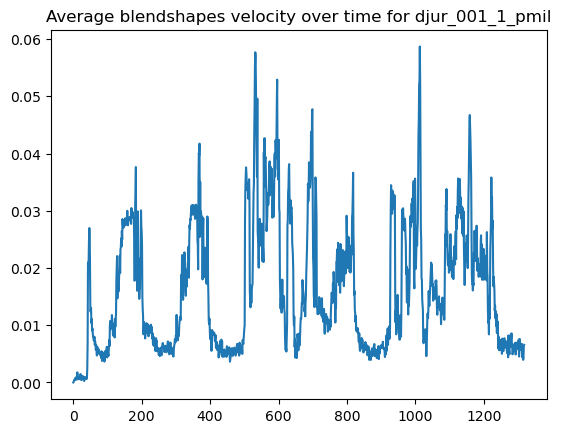

In [86]:
average_velocities = [vel["velocity"] for vel in video_blendshapes["djur_001_1_pmil"]]
# plot velocities
plt.figure()
plt.plot(average_velocities)
plt.title("Average blendshapes velocity over time for djur_001_1_pmil")

In [92]:
# smooth velocities with MA = 5
# 127 folders total in the root directory (this includes "bad" takes, actually I have 90 good takes)

count_files_progress = 0

for root, dirs, files in os.walk("./"):
    if root.split('/')[-1].startswith("20241101"):
        video_fps = 60
        video_name = '_'.join(root.split('/')[-1].split('_')[1:]) + "_pmil"
        print(video_name)

        window_size = 5
        # smooth velocities
        for k, frame in enumerate(video_blendshapes[video_name]):
            if k < window_size:
                video_blendshapes[video_name][k]["smoothed_velocity"] = frame["velocity"]
                continue
            velocities = [frame["velocity"] for frame in video_blendshapes[video_name][k-window_size:k]]
            video_blendshapes[video_name][k]["smoothed_velocity"] = np.mean(velocities)
        count_files_progress += 1
        print(f"Progress: {count_files_progress/126 * 100}%")


static_ROOF_fingers_contact_at_45_degrees_neutral_location_001_1_pmil
Progress: 0.7936507936507936%
varg_001_1_pmil
Progress: 1.5873015873015872%
bi_005_5_pmil
Progress: 2.380952380952381%
fran_001_1_pmil
Progress: 3.1746031746031744%
parti-vill-kalla-grupp-for-terrorister-1-det_001_1_pmil
Progress: 3.968253968253968%
parti-vill-kalla-grupp-for-terrorister-4-nu_002_2_pmil
Progress: 4.761904761904762%
katt_001_1_pmil
Progress: 5.555555555555555%
bok_002_2_pmil
Progress: 6.349206349206349%
varg_003_3_pmil
Progress: 7.142857142857142%
parti-vill-kalla-grupp-for-terrorister-1-det_003_3_pmil
Progress: 7.936507936507936%
djur_001_1_pmil
Progress: 8.73015873015873%
abborre_002_2_pmil
Progress: 9.523809523809524%
parti-vill-kalla-grupp-for-terrorister-5-bosattarna_003_3_pmil
Progress: 10.317460317460316%
parti-vill-kalla-grupp-for-terrorister-7-det_001_1_pmil
Progress: 11.11111111111111%
hundvalp_001_1_pmil
Progress: 11.904761904761903%
left_hand_on_top_of_the_battery_neutral_location_001_1_pm

Text(0.5, 1.0, 'Average blendshapes velocity smoothed w=5 over time for djur_001_1_pmil')

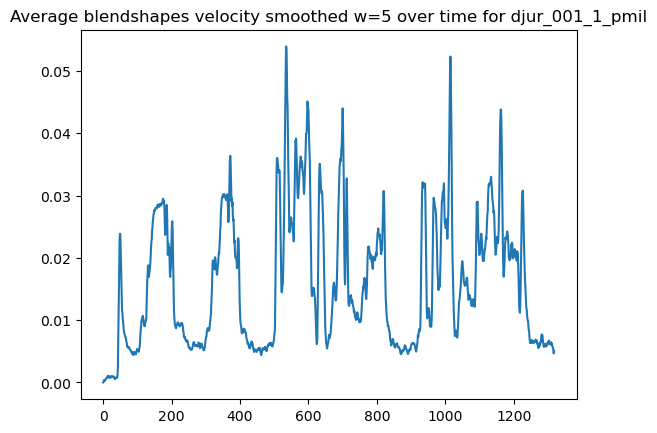

In [93]:
average_velocities = [vel["smoothed_velocity"] for vel in video_blendshapes["djur_001_1_pmil"]]
# plot velocities
plt.figure()
plt.plot(average_velocities)
plt.title("Average blendshapes velocity smoothed w=5 over time for djur_001_1_pmil")

In [94]:
# save to npz
np.savez("blendshapes_timecodes_velocities.npz", video_blendshapes=video_blendshapes)

### Is there a correlation between frame drops and occlusions

In [69]:
for root, dirs, files in os.walk("./"):
    if root.split('/')[-1].startswith("20241101"):
        video_fps = 60
        video_name = '_'.join(root.split('/')[-1].split('_')[1:]) + "_pmil"
        print(video_name)
        if video_name == "static_ROOF_fingers_contact_at_45_degrees_in_front_of_the_face_location_001_1_pmil":
            continue

        file = "frame_log.csv"
        frame_log_df = pd.read_csv(os.path.join(root, f"frame_log.csv"), sep=",", header=None)
        # assign column names
        frame_log_df.columns = ["data_source", "frame_relative_to_source", "timestamp", "timescale", "timecode_tentacle", "unclear"]
        print(len(frame_log_df[frame_log_df["data_source"] == "V"]["frame_relative_to_source"].to_list()))

static_ROOF_fingers_contact_at_45_degrees_neutral_location_001_1_pmil
354
varg_001_1_pmil
824
bi_005_5_pmil
387
fran_001_1_pmil
1200
parti-vill-kalla-grupp-for-terrorister-1-det_001_1_pmil
583
parti-vill-kalla-grupp-for-terrorister-4-nu_002_2_pmil
169
katt_001_1_pmil
1046
bok_002_2_pmil
1121
varg_003_3_pmil
1065
parti-vill-kalla-grupp-for-terrorister-1-det_003_3_pmil
778
djur_001_1_pmil
1319
abborre_002_2_pmil
1169
parti-vill-kalla-grupp-for-terrorister-5-bosattarna_003_3_pmil
636
parti-vill-kalla-grupp-for-terrorister-7-det_001_1_pmil
521
hundvalp_001_1_pmil
479
left_hand_on_top_of_the_battery_neutral_location_001_1_pmil
381
parti-vill-kalla-grupp-for-terrorister-5-bosattarna_001_1_pmil
1295
touch_chin_with_index_finger_side_of_the_chin_far_from_active_hand_active_hand_001_1_pmil
519
ogon_cheeks_active_hand_in_each_place_001_1_pmil
531
mussla_002_2_pmil
1358
right_hand_above_belly_button_001_1_pmil
480
static_ROOF_fingers_contact_at_45_degrees_left_top_location_001_1_pmil
456
skara_00